In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [ ]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [3]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [4]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [5]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [6]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

In [7]:
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader
import torch

# 1. Extract all data from train_dataset
X_list, y_list = [], []
for i in range(len(train_dataset)):
    X, y = train_dataset[i]
    X_list.append(X.flatten())  # Flatten if needed
    y_list.append(y)

X = np.stack(X_list)  # shape: [n_samples, n_features]
y = np.array(y_list)

# 2. Apply SMOTE ENN
smote_enn = SMOTE(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# 3. Convert back to torch tensors and create DataLoader
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.float32)

train_dataset_balanced = TensorDataset(X_resampled, y_resampled)
loader_tr = DataLoader(train_dataset_balanced, batch_size=512, shuffle=True)

In [8]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Bidirectional LSTM model for sequential data

In this section, we train a bidirectional lstm model with an mlp for the sequence classification.

In [9]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            bidirectional=True  # Enable bidirectional LSTM
        )
        # Multiply hidden_dim by 6: 2 for bidirectional, 3 for first, last, and mean
        self.fc1 = nn.Linear(hidden_dim * 6, hidden_dim)  # First linear layer
        self.relu = nn.ReLU()  # ReLU activation
        self.fc2 = nn.Linear(hidden_dim, 1)

    def extract_features(self, x):
        out, (h_n, c_n) = self.lstm(x)
        first_timestep = out[:, 0, :]
        last_timestep = out[:, -1, :]
        mean_timestep = out.mean(dim=1)
        combined = torch.cat((first_timestep, last_timestep, mean_timestep), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        return x  # [batch_size, hidden_dim]

    def forward(self, x):
        feats = self.extract_features(x)
        logits = self.fc2(feats)
        return logits

In [ ]:
model = BiLSTM(input_dim=19, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
class_weight = 4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        batch_size = x_batch.shape[0]
        seq_len =  x_batch.shape[1] // 19
        x_batch = x_batch.view(batch_size, seq_len, 19)
        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            # Move data to GPU (if available)
            x_val = x_val.float().to(device)  # [batch_size, seq_len, input_dim]
            y_val = y_val.float().unsqueeze(1).to(device)  # [batch_size, 1]

            # Forward pass
            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)  # Apply sigmoid for binary classification
            val_preds = (val_probs > 0.5).int()  # Convert probabilities to binary predictions

            # Collect all labels and predictions
            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            # Compute validation loss
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val)
    val_losses.append(avg_val_loss)

    # Compute metrics for validation data
    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    print(val_f1)

Training:   1%|▍                                                | 1/100 [00:01<02:39,  1.61s/it]

0.15208231487301255


Training:   2%|▉                                                | 2/100 [00:02<02:18,  1.41s/it]

0.15445812640755305


Training:   3%|█▍                                               | 3/100 [00:04<02:10,  1.35s/it]

0.3667441178461053


Training:   4%|█▉                                               | 4/100 [00:05<02:06,  1.32s/it]

0.4724085893708944


Training:   5%|██▍                                              | 5/100 [00:06<02:03,  1.30s/it]

0.5483872537805964


Training:   6%|██▉                                              | 6/100 [00:07<02:01,  1.29s/it]

0.3776023277401627


Training:   7%|███▍                                             | 7/100 [00:09<01:59,  1.28s/it]

0.4748389757335979


Training:   8%|███▉                                             | 8/100 [00:10<01:57,  1.28s/it]

0.4509732740239688


Training:   9%|████▍                                            | 9/100 [00:11<01:56,  1.28s/it]

0.4888630471088965


Training:  10%|████▊                                           | 10/100 [00:13<01:55,  1.28s/it]

0.3159284815049435


Training:  11%|█████▎                                          | 11/100 [00:14<01:53,  1.28s/it]

0.5217598712263346


Training:  12%|█████▊                                          | 12/100 [00:15<01:52,  1.27s/it]

0.6491093739491234


Training:  13%|██████▏                                         | 13/100 [00:16<01:50,  1.27s/it]

0.5472501841993549


Training:  14%|██████▋                                         | 14/100 [00:18<01:49,  1.27s/it]

0.5551143037368949


Training:  15%|███████▏                                        | 15/100 [00:19<01:48,  1.27s/it]

0.30735467702524905


Training:  16%|███████▋                                        | 16/100 [00:20<01:46,  1.27s/it]

0.3653990318301905


Training:  17%|████████▏                                       | 17/100 [00:21<01:45,  1.27s/it]

0.5280701679742678


Training:  18%|████████▋                                       | 18/100 [00:23<01:44,  1.27s/it]

0.6571721309892032


Training:  19%|█████████                                       | 19/100 [00:24<01:42,  1.27s/it]

0.5447215129509909


Training:  20%|█████████▌                                      | 20/100 [00:25<01:41,  1.27s/it]

0.6228029504741833


Training:  21%|██████████                                      | 21/100 [00:27<01:43,  1.32s/it]

0.5873829482543742


Training:  22%|██████████▌                                     | 22/100 [00:28<01:41,  1.30s/it]

0.5510621346375353


Training:  23%|███████████                                     | 23/100 [00:29<01:39,  1.29s/it]

0.634173475941729


Training:  24%|███████████▌                                    | 24/100 [00:30<01:37,  1.29s/it]

0.6868319152188311


Training:  25%|████████████                                    | 25/100 [00:32<01:36,  1.28s/it]

0.6797225622195022


Training:  26%|████████████▍                                   | 26/100 [00:33<01:34,  1.28s/it]

0.6174099751655628


Training:  27%|████████████▉                                   | 27/100 [00:34<01:33,  1.28s/it]

0.5258802022743999


Training:  28%|█████████████▍                                  | 28/100 [00:36<01:31,  1.28s/it]

0.5097095825984714


Training:  29%|█████████████▉                                  | 29/100 [00:37<01:30,  1.27s/it]

0.6464662398808534


Training:  30%|██████████████▍                                 | 30/100 [00:38<01:29,  1.28s/it]

0.6589603004822895


Training:  31%|██████████████▉                                 | 31/100 [00:39<01:27,  1.27s/it]

0.6805583979750334


Training:  32%|███████████████▎                                | 32/100 [00:41<01:26,  1.27s/it]

0.6658462670357006


Training:  33%|███████████████▊                                | 33/100 [00:42<01:25,  1.27s/it]

0.6239852002024745


Training:  34%|████████████████▎                               | 34/100 [00:43<01:24,  1.28s/it]

0.5783714607244019


Training:  35%|████████████████▊                               | 35/100 [00:44<01:22,  1.27s/it]

0.7070070699720361


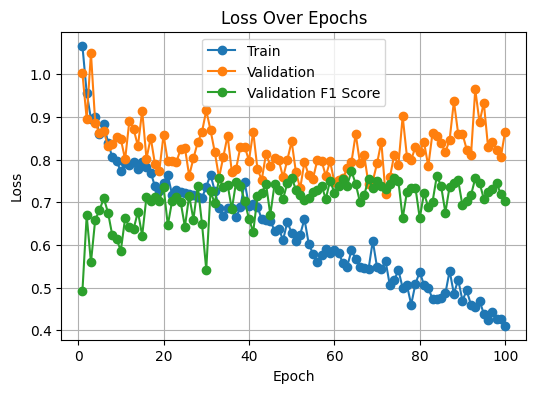

In [ ]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_precision_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_recall_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score", "Validation Precision", "Validation Recall"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Submission

In [ ]:
data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
model = BiLSTM(input_dim=19, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor().to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 100
train_losses = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

Training: 100%|███████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Assume model is trained using your PyTorch loop above ===

def extract_features_from_loader(model, loader, test=False):
    model.eval()
    feats = []
    labels = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.float().to(device)
            # Extract features as in BiLSTM.extract_features
            features = model.extract_features(x_batch).cpu().numpy()
            feats.append(features)
            if not test:
                labels.append(y_batch.cpu().numpy())
            else:
                labels.append(y_batch)
    X_feats = np.concatenate(feats, axis=0)
    y_labels = np.concatenate(labels, axis=0).flatten()
    return X_feats, y_labels

# === Feature extraction ===
X_train_feats, y_train = extract_features_from_loader(model, loader_tr)
X_te_feats, all_ids = extract_features_from_loader(model, loader_te, test=True)

# === Train XGBoost Classifier ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_feats, y_train)

# === Predict and Evaluate ===
all_predictions = xgb_model.predict(X_te_feats)



# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_xgb_seed2.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv


/home/pavlovic/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:41:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
